<div style="background-color: #fdf6e3;
            border-left: 8px solid #ff6f61;
            padding: 20px;
            border-radius: 12px;
            font-family: Arial, sans-serif;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            color: #2c3e50;
            line-height: 1.6;
            font-size: 15px;">

<b style="color:#ff6f61; font-size:20px;">Project Objective: Covid-19 & Pneumonia X-Ray Detector</b>

<b style="color:#34495e;">Why this project matters:</b>
Doctors often face difficulty in telling the difference between Covid-19, Viral Pneumonia, and Bacterial Pneumonia just by looking at chest X-rays. A wrong or delayed diagnosis can risk lives. This project builds an AI model that helps doctors make quicker and more reliable decisions.

<b style="color:#34495e;">Problem Statement</b>
The challenge is to correctly classify chest X-rays into four categories:
<ul>
  <li><b>Normal (Healthy)</b></li>
  <li><b>Covid-19</b></li>
  <li><b>Viral Pneumonia</b></li>
  <li><b>Bacterial Pneumonia</b></li>
</ul>

<b style="color:#34495e;">Dataset</b>
A custom dataset was created using publicly available images:
<ul>
  <li>Covid-19 X-ray images</li>
  <li>Pneumonia (Viral & Bacterial) images</li>
</ul>
Each category (Covid-19, Normal, Viral Pneumonia, Bacterial Pneumonia) contains <b>133 X-ray images</b> for training the model.

<b style="color:#34495e;">Outcome:</b>
✅ Build a deep learning model to classify chest X-rays into 4 categories  
✅ Assist doctors in faster and more accurate diagnosis  
✅ Reduce the risk of misdiagnosis between Covid-19 and Pneumonia  
✅ Improve hospital efficiency by automating detection  

<hr style="border: none; height: 1px; background-color: #ddd; margin: 15px 0;">
<span style="display:block; text-align:right; font-style:italic; color:#7f8c8d; font-size:14px;">
— Authored by <b style="color:#ff6f61;">Utkarsh Shukla</b>
</span>
</div>


# TASK #1: IMPORT LIBRARIES AND DATASET

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [9]:
# Specify training data directory
XRay_Directory = 'Operations Department'

In [10]:
# List the folders in the directory
os.listdir(XRay_Directory)

['Dataset', 'README.md', 'Test']

In [11]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [49]:
# Generate batches of 4 images (reduced batch size to match training)
train_generator = image_generator.flow_from_directory(
    batch_size=4,
    directory=XRay_Directory,
    shuffle=True,
    target_size=(256,256),
    class_mode='categorical',
    subset="training"
)
print("Training classes:", train_generator.class_indices)

Found 428 images belonging to 4 classes.
Training classes: {'0': 0, '1': 1, '2': 2, '3': 3}


In [50]:
validation_generator = image_generator.flow_from_directory(
    batch_size=4,
    directory=XRay_Directory,
    shuffle=True,
    target_size=(256,256),
    class_mode='categorical',
    subset="validation"
)
print("Validation classes:", validation_generator.class_indices)

Found 104 images belonging to 4 classes.
Validation classes: {'0': 0, '1': 1, '2': 2, '3': 3}


In [51]:
# Generate a batch of 4 images and labels
train_images, train_labels = next(train_generator)

In [52]:
train_images.shape

(4, 256, 256, 3)

In [53]:
train_labels.shape

(4, 4)

In [55]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [56]:
# labels Translator
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

## TASK #2: VISUALIZE DATASET

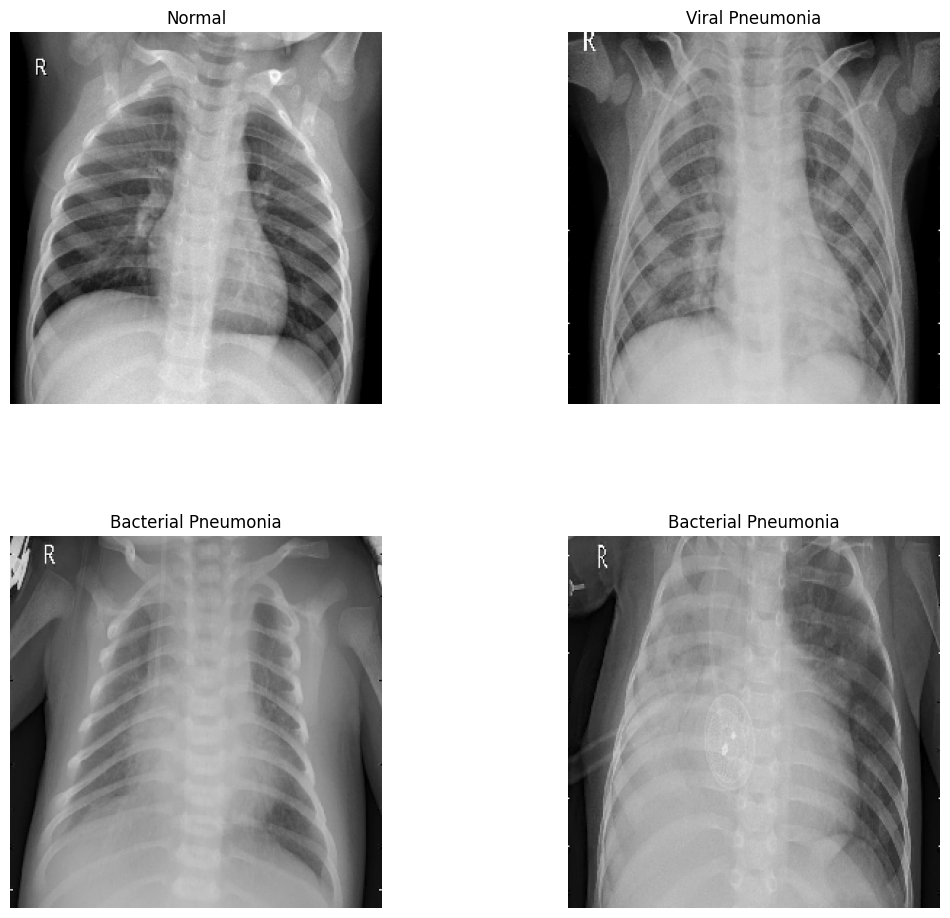

In [60]:
# Create a grid of 36 images along with their corresponding labels
L = 2
W = 2

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# TASK #3: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [61]:
# Clear session to prevent variable conflicts
tf.keras.backend.clear_session()

# Load ResNet50 base model
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

In [62]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [63]:
# Freezing the model up to the last stage - 4 and re-training stage -5
for layer in basemodel.layers[:-10]:
    layer.trainable = False  # Corrected from layers.trainable

# TASK #4: BUILD AND TRAIN DEEP LEARNING MODEL

In [64]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation="relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)

In [65]:
optimizer = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [66]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.keras", 
                               verbose=1, 
                               save_best_only=True, 
                               monitor="val_loss", 
                               mode="min")

In [67]:
# Temporarily disable tf.function to debug variable creation issue
tf.config.run_functions_eagerly(True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 4,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // 4,
    callbacks=[checkpointer, earlystopping]
)

# Re-enable tf.function
tf.config.run_functions_eagerly(False)

Epoch 1/10


C:\Users\UTKARSH SHUKLA\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3012 - loss: 1.5696
Epoch 1: val_loss improved from None to 1.29130, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3762 - loss: 1.3678 - val_accuracy: 0.4038 - val_loss: 1.2913
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5433 - loss: 1.1184
Epoch 2: val_loss did not improve from 1.29130
107/107 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5584 - loss: 1.0740 - val_accuracy: 0.3269 - val_loss: 1.2989
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5758 - loss: 1.0386
Epoch 3: val_loss improved from 1.29130 to 1.00057, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6285 - loss: 0.9440 - val_accuracy: 0.5577 - val_loss: 1.0006
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6867 - loss: 0.8302
Epoch 4: val_loss improved from 1.00057 to 0.90035, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━

# TASK #4: EVALUATE TRAINED DEEP LEARNING MODEL

In [68]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

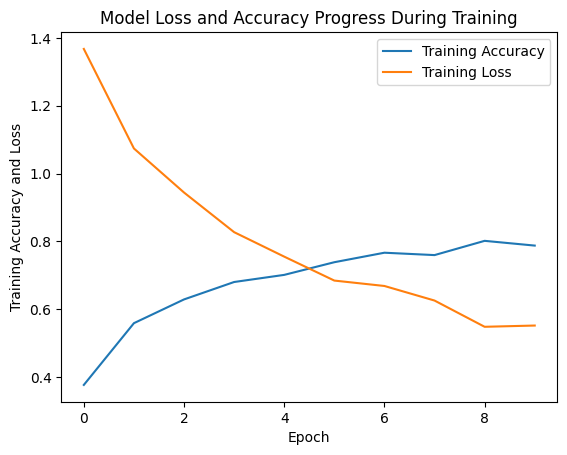

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

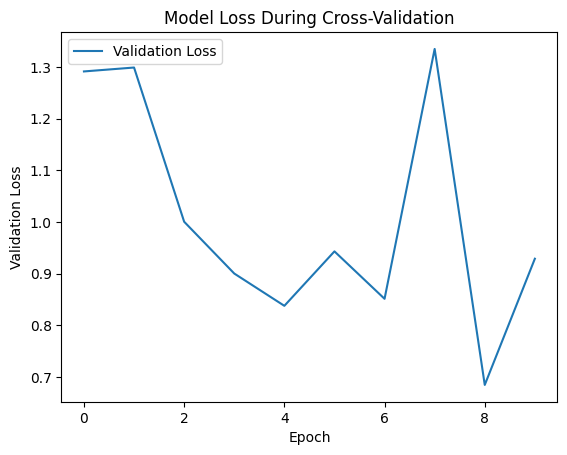

In [70]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

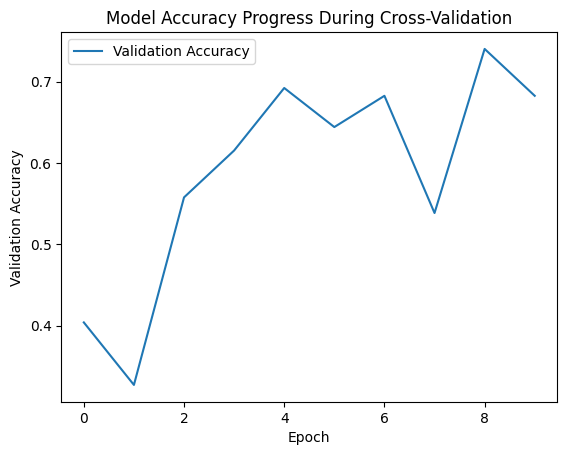

In [71]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [72]:
test_directory = 'Operations Department/Test'


In [74]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    batch_size=40,
    directory=test_directory,
    shuffle=True,
    target_size=(256,256),
    class_mode='categorical'
)
evaluate = model.evaluate(test_generator, steps=test_generator.n // 4, verbose=1)
print('Accuracy Test: {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7000 - loss: 0.8937
Accuracy Test: 0.699999988079071


C:\Users\UTKARSH SHUKLA\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [77]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━

In [78]:
len(original)

40

In [79]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7


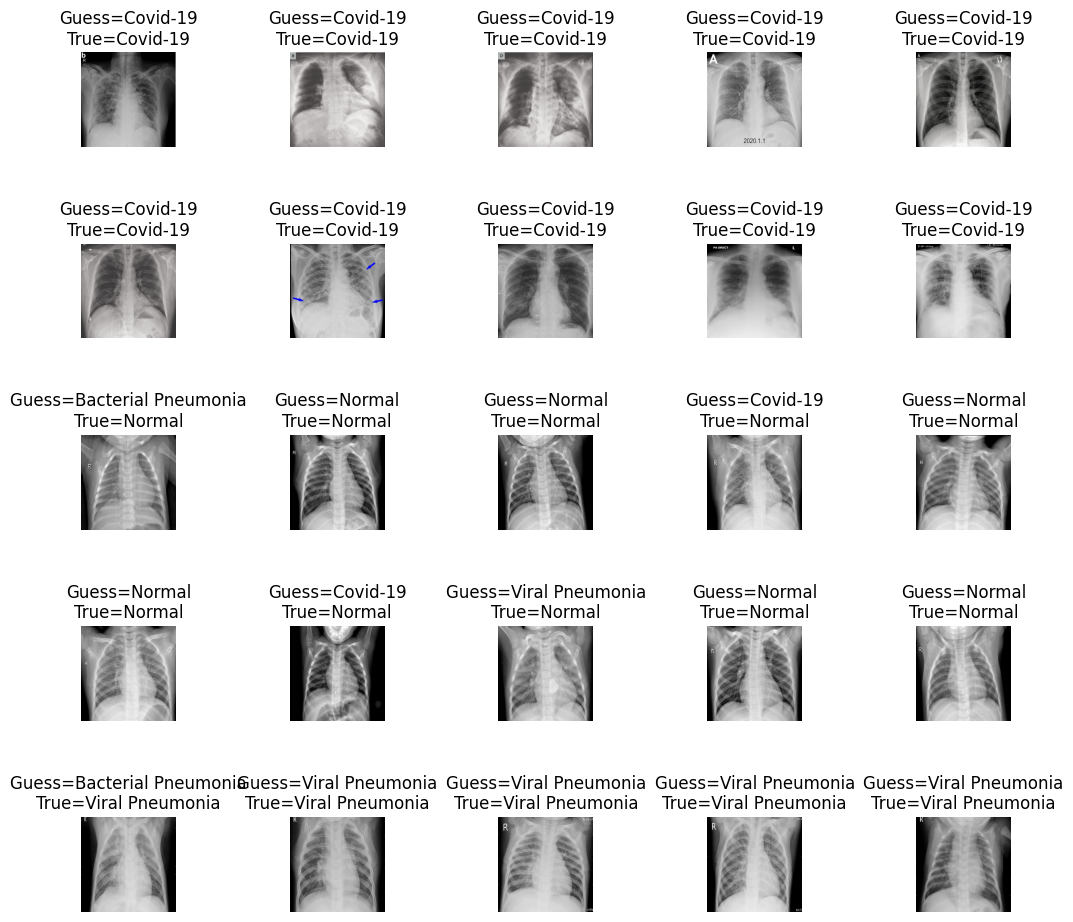

In [80]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [81]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.67      0.60      0.63        10
           2       0.83      0.50      0.62        10
           3       0.70      0.70      0.70        10

    accuracy                           0.70        40
   macro avg       0.72      0.70      0.69        40
weighted avg       0.72      0.70      0.69        40



Text(0.5, 1.0, 'Confusion_matrix')

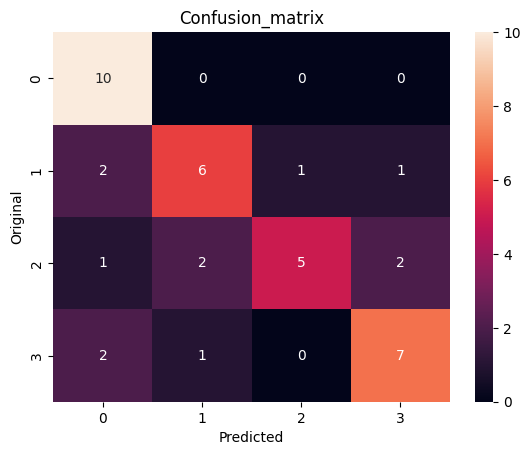

In [82]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')